# Import required Libraries

In [1]:
# --- Import Required Libraries ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


2025-05-29 18:16:33.802155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load the Dataset

In [2]:
# Load Dataset
df = pd.read_csv("resources/SpotifyFeatures.csv")
# View basic info
df.info()  # Check column types & missing values
df.head()  # Preview first few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


# Data Preprocessing

In [3]:
# --- Data Preprocessing & Feature Selection ---
df["mode"] = df["mode"].map({"Major": 1, "Minor": 0})  # Convert Major/Minor to numeric
artist_encoder = LabelEncoder()
df["artist_encoded"] = artist_encoder.fit_transform(df["artist_name"])  # Encode artist names

# Convert categorical features to numeric
key_mapping = {k: i for i, k in enumerate(["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"])}
df["key"] = df["key"].map(key_mapping).fillna(-1)  # Convert musical keys to numbers
df["time_signature"] = df["time_signature"].astype(str).str.extract(r'(\d+)').astype(float).fillna(df["time_signature"].mode()[0])  # Convert time_signature

# Compute rough song length metric
df["song_length"] = df["tempo"] * df["time_signature"]

# --- Speed Optimization: Use a Smaller Sample ---
df_sample = df.sample(3000, random_state=42).reset_index(drop=True)

# Encode genre labels numerically and ensure they start at 0
# Fit the encoder on the genres present in df_sample to avoid unseen labels
genre_encoder = LabelEncoder()
df_sample["genre_encoded"] = genre_encoder.fit_transform(df_sample["genre"])
df_sample["genre_encoded"] -= df_sample["genre_encoded"].min()  # Ensure labels start at 0

# Define important features for classification
important_features = ["danceability", "energy", "tempo", "acousticness",
                      "instrumentalness", "valence", "loudness", "speechiness",
                      "artist_encoded", "song_length", "key", "genre_encoded"]  # Removed mode & time_signature

# --- Handle Genre Issues ---
df_sample = df_sample[df_sample["genre"] != "A Capella"]  # Remove rare genre
df_sample["genre"] = df_sample["genre"].replace("Children’s Music", "Children's Music")  # Standardize genre names

# Remove columns with all NaN values
features_no_nan = [col for col in important_features if not df_sample[col].isna().all()]

df_sample.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_encoded,song_length,genre_encoded
0,Country,A Thousand Horses,My Time's Comin',16zol4GvHyTER5irYODUk0,45,0.00192,0.327,194107,0.8350,0.000150,...,0.1670,-4.952,1,0.0609,171.795,4.0,0.3850,103,687.180,8
1,Soundtrack,Mark Mothersbaugh,House Tour,6ac5gUfGTckpdGQCyWsdh2,25,0.93200,0.253,102920,0.0798,0.568000,...,0.0906,-18.512,1,0.0439,110.931,4.0,0.0487,8228,443.724,25
2,Reggae,Unified Highway,We Can't Fall (Remix) [feat. J. Patz],09Yz6koF1Y15n1012t1UX6,19,0.03310,0.821,225437,0.7370,0.013400,...,0.1320,-6.295,0,0.2120,137.968,4.0,0.7870,13592,551.872,20
3,Electronic,Stooki Sound,Endz - Original Mix,3dzEZARDL4ZwICMKVta7Xn,29,0.00428,0.745,225400,0.7720,0.114000,...,0.0722,-3.949,1,0.0904,133.113,4.0,0.1700,11818,532.452,10
4,Comedy,Bill Hicks,I Love My Job (Live),39Z1G5384UgGa5vmW6WyxC,17,0.96500,0.502,287973,0.8040,0.000096,...,0.9020,-9.935,1,0.8070,104.576,3.0,0.1850,1424,313.728,7


danceability        float64
energy              float64
tempo               float64
acousticness        float64
instrumentalness    float64
valence             float64
loudness            float64
speechiness         float64
artist_encoded        int64
song_length         float64
key                   int64
genre_encoded         int64
dtype: object


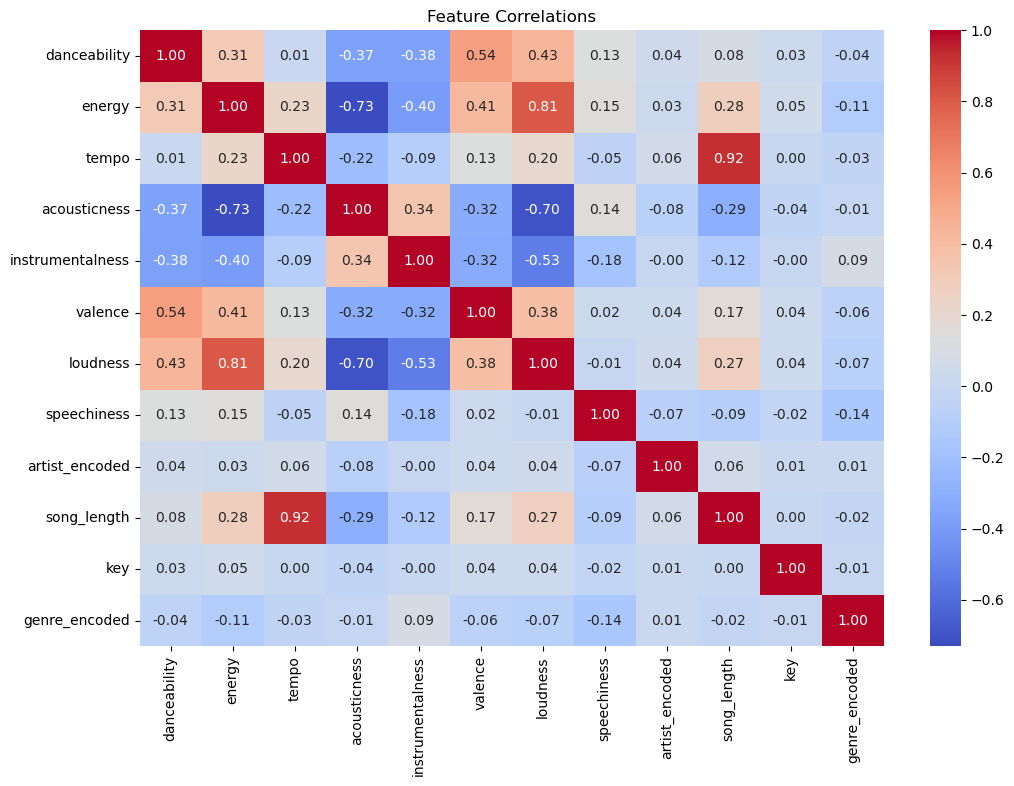

Unique classes in training data: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Unique classes in test data: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
             Feature  Importance
11     genre_encoded    0.383680
7        speechiness    0.088646
3       acousticness    0.067674
0       danceability    0.065281
1             energy    0.060750
6           loudness    0.059851
5            valence    0.057347
4   instrumentalness    0.057010
8     artist_encoded    0.048334
9        song_length    0.041551
2              tempo    0.040146
10               key    0.029730
Random Forest Genre Classification Accuracy: 0.91


In [4]:
# Scale Features
scaler = StandardScaler()
X_scaled_df = pd.DataFrame(scaler.fit_transform(df_sample[features_no_nan]), columns=features_no_nan)

# Validate Feature Types & Correlation Check
print(df_sample[features_no_nan].dtypes)  # Ensure all features are numeric
plt.figure(figsize=(12,8))
sns.heatmap(df_sample[important_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations")
plt.show()

# --- Genre Classification Model ---
X = X_scaled_df  # Features (scaled)
y = df_sample["genre_encoded"]  # Target labels (encoded genre)

# Split dataset into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Debugging Step: Check Class Labels Before Training
print("Unique classes in training data:", np.unique(y_train))
print("Unique classes in test data:", np.unique(y_test))

# --- Feature Importance Analysis ---
rf_temp = RandomForestClassifier(n_estimators=100)
rf_temp.fit(X_train, y_train)
importances = rf_temp.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": features_no_nan, "Importance": importances})
feature_importance_df.sort_values("Importance", ascending=False, inplace=True)
print(feature_importance_df)  # Review top features

# --- Train Optimized Random Forest Model with Class Balancing ---
rf_model = RandomForestClassifier(n_estimators=150, max_depth=12, min_samples_split=5, class_weight="balanced", n_jobs=-1)  # Class weighting instead of SMOTE
rf_model.fit(X_train, y_train)

# Evaluate Random Forest Model
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest Genre Classification Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")


# Apply PCA for Dimensionality Reduction

In [5]:
# Apply PCA(Principal Component Analysis) for Dimensionality Reduction
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled_df)
print(f"Explained Variance Ratio: {sum(pca.explained_variance_ratio_):.2f}")  # Check variance retention

# Create DataFrame for PCA results
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7"])
pca_df["artist_name"] = df_sample["artist_name"].values
pca_df["original_index"] = df_sample.index  # Keep original index for mapping clusters
pca_df.head()  # Preview PCA DataFrame


Explained Variance Ratio: 0.87


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,artist_name,original_index
0,1.643760,2.135850,1.222698,-2.210150,-1.250752,0.545164,-0.613803,A Thousand Horses,0
1,-3.842493,1.404110,-0.554986,-1.305648,0.883287,-0.005891,0.707469,Mark Mothersbaugh,1
2,2.231903,0.094958,-0.506548,0.397957,1.807479,-0.346800,0.708369,Unified Highway,2
3,1.485524,0.427418,-0.283891,0.037895,0.331181,1.351192,0.253964,Stooki Sound,3
4,-0.909434,-1.976090,3.465671,0.101808,-1.317128,0.007273,1.868595,Bill Hicks,4


# Apply K-Means Clustering

In [6]:
# Silhouette Score for Clustering
for k in range(2, 10):  # Avoid k=1 (single cluster isn't useful)
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_test.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")


Clusters: 2, Silhouette Score: 0.2860
Clusters: 3, Silhouette Score: 0.1779
Clusters: 4, Silhouette Score: 0.2020
Clusters: 5, Silhouette Score: 0.1700
Clusters: 6, Silhouette Score: 0.1544
Clusters: 7, Silhouette Score: 0.1467
Clusters: 8, Silhouette Score: 0.1444
Clusters: 9, Silhouette Score: 0.1382


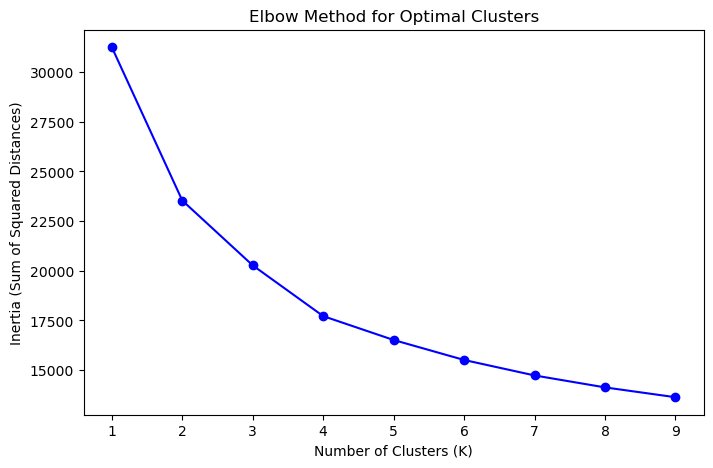

In [7]:
# Elbow Method to Determine Optimal Number of Clusters
# The Elbow Method helps to find the optimal number of clusters by plotting the inertia (sum of squared distances)
# Define range of clusters to test
num_clusters = range(1, 10)  # Testing 1 to 10 clusters
inertia_values = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia_values.append(kmeans.inertia_)  # Store inertia for each cluster count

# Plot the elbow curve
plt.figure(figsize=(8,5))
plt.plot(num_clusters, inertia_values, marker="o", linestyle="-", color="blue")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal Clusters")
plt.show()


In [8]:
# Davies-Bouldin Index (DBI) is another useful metric to evaluate clustering quality.
# Compute DBI for different cluster numbers (K=2 to K=9)
# LEAST DBI indicates better clustering quality
for k in range(2, 10):  
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)  # Fit K-Means clustering
    dbi_score = davies_bouldin_score(X_pca, labels)  # Compute DBI
    print(f"Clusters: {k}, Davies-Bouldin Score: {dbi_score:.4f}")


Clusters: 2, Davies-Bouldin Score: 1.3799
Clusters: 3, Davies-Bouldin Score: 1.8254
Clusters: 4, Davies-Bouldin Score: 1.5404
Clusters: 5, Davies-Bouldin Score: 1.7173
Clusters: 6, Davies-Bouldin Score: 1.7286
Clusters: 7, Davies-Bouldin Score: 1.6972
Clusters: 8, Davies-Bouldin Score: 1.8086
Clusters: 9, Davies-Bouldin Score: 1.7909


In [9]:
# Perform K-Means Clustering
# Group similar songs based on their PCA-transformed features.
kmeans = KMeans(n_clusters= 2, random_state=42, n_init=10)
# 
df_sample["Cluster"] = kmeans.fit_predict(X_pca)
# Merge Cluster Labels into PCA DataFrame
pca_df["Cluster"] = df_sample.loc[pca_df["original_index"], "Cluster"].values



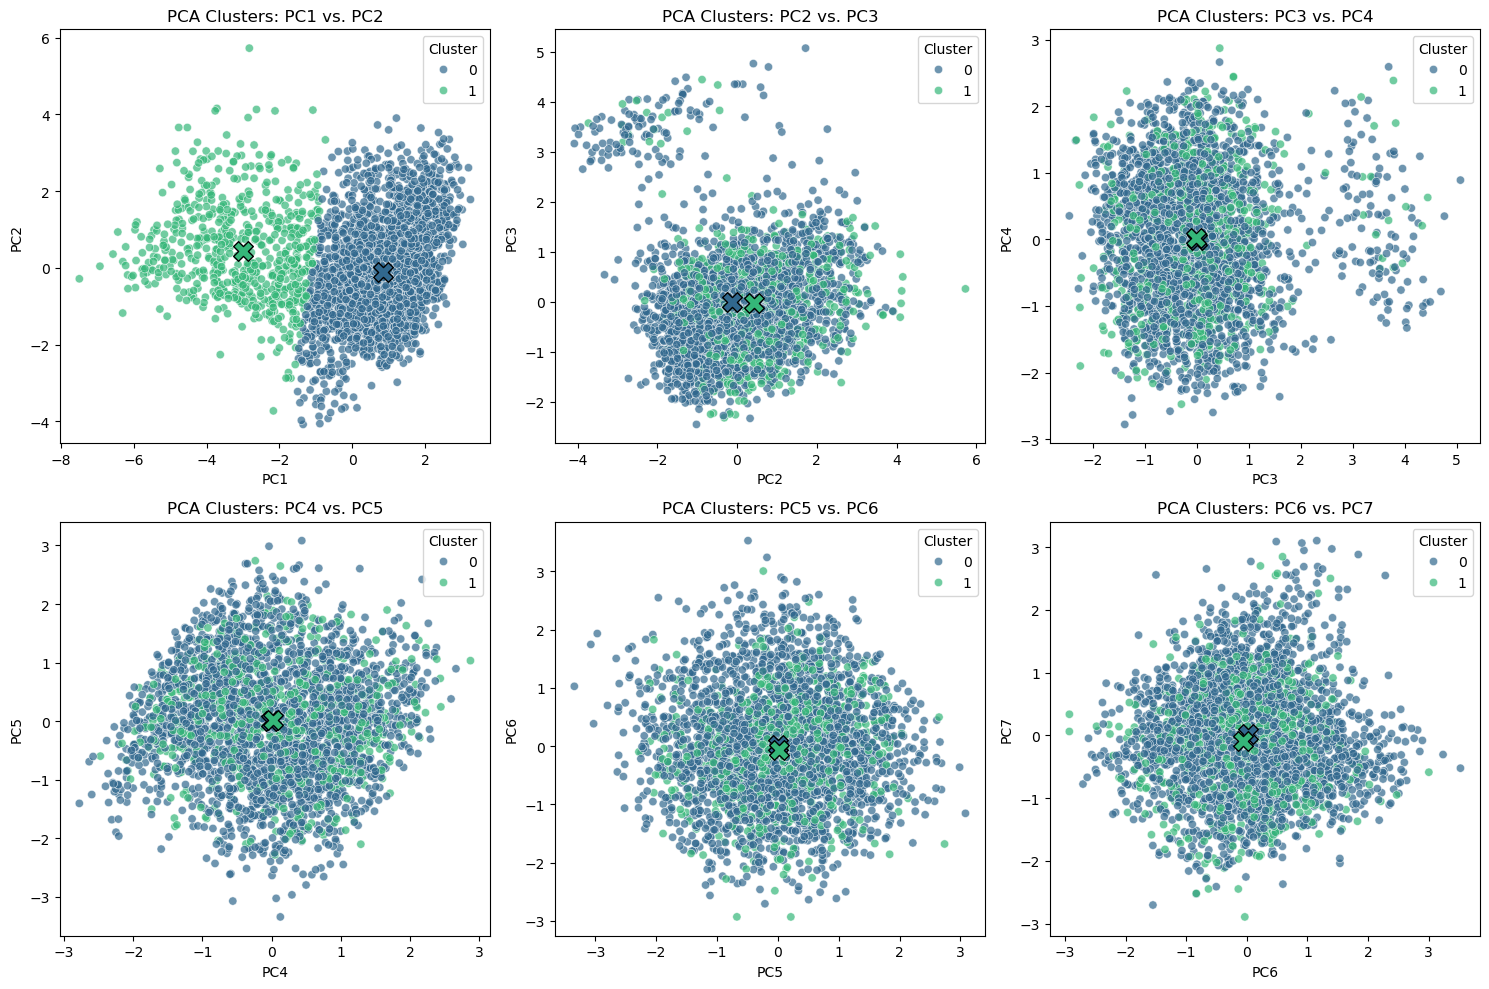

In [10]:
# Define PCA components to plot
pca_pairs = [("PC1", "PC2"), ("PC2", "PC3"), ("PC3", "PC4"), ("PC4", "PC5"), ("PC5", "PC6"), ("PC6", "PC7")]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (pc_x, pc_y) in enumerate(pca_pairs):
    ax = axes[i]
    
    # Scatter plot of PCA clusters
    sns.scatterplot(
        x=pca_df[pc_x], 
        y=pca_df[pc_y], 
        hue=pca_df["Cluster"].astype(str), 
        palette="viridis", 
        alpha=0.7, 
        ax=ax
    )
    
    # Compute centroids
    centroids = pca_df.groupby("Cluster")[[pc_x, pc_y]].mean()
    
    # Extract cluster colors from the scatter plot
    cluster_palette = dict(zip(pca_df["Cluster"].unique(), sns.color_palette("viridis", len(pca_df["Cluster"].unique()))))

    # Plot centroids with matching cluster colors
    for cluster, row in centroids.iterrows():
        ax.scatter(row[pc_x], row[pc_y], marker="X", s=200, c=[cluster_palette[cluster]], edgecolors="black")

    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y)
    ax.set_title(f"PCA Clusters: {pc_x} vs. {pc_y}")

plt.tight_layout()
plt.show()


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


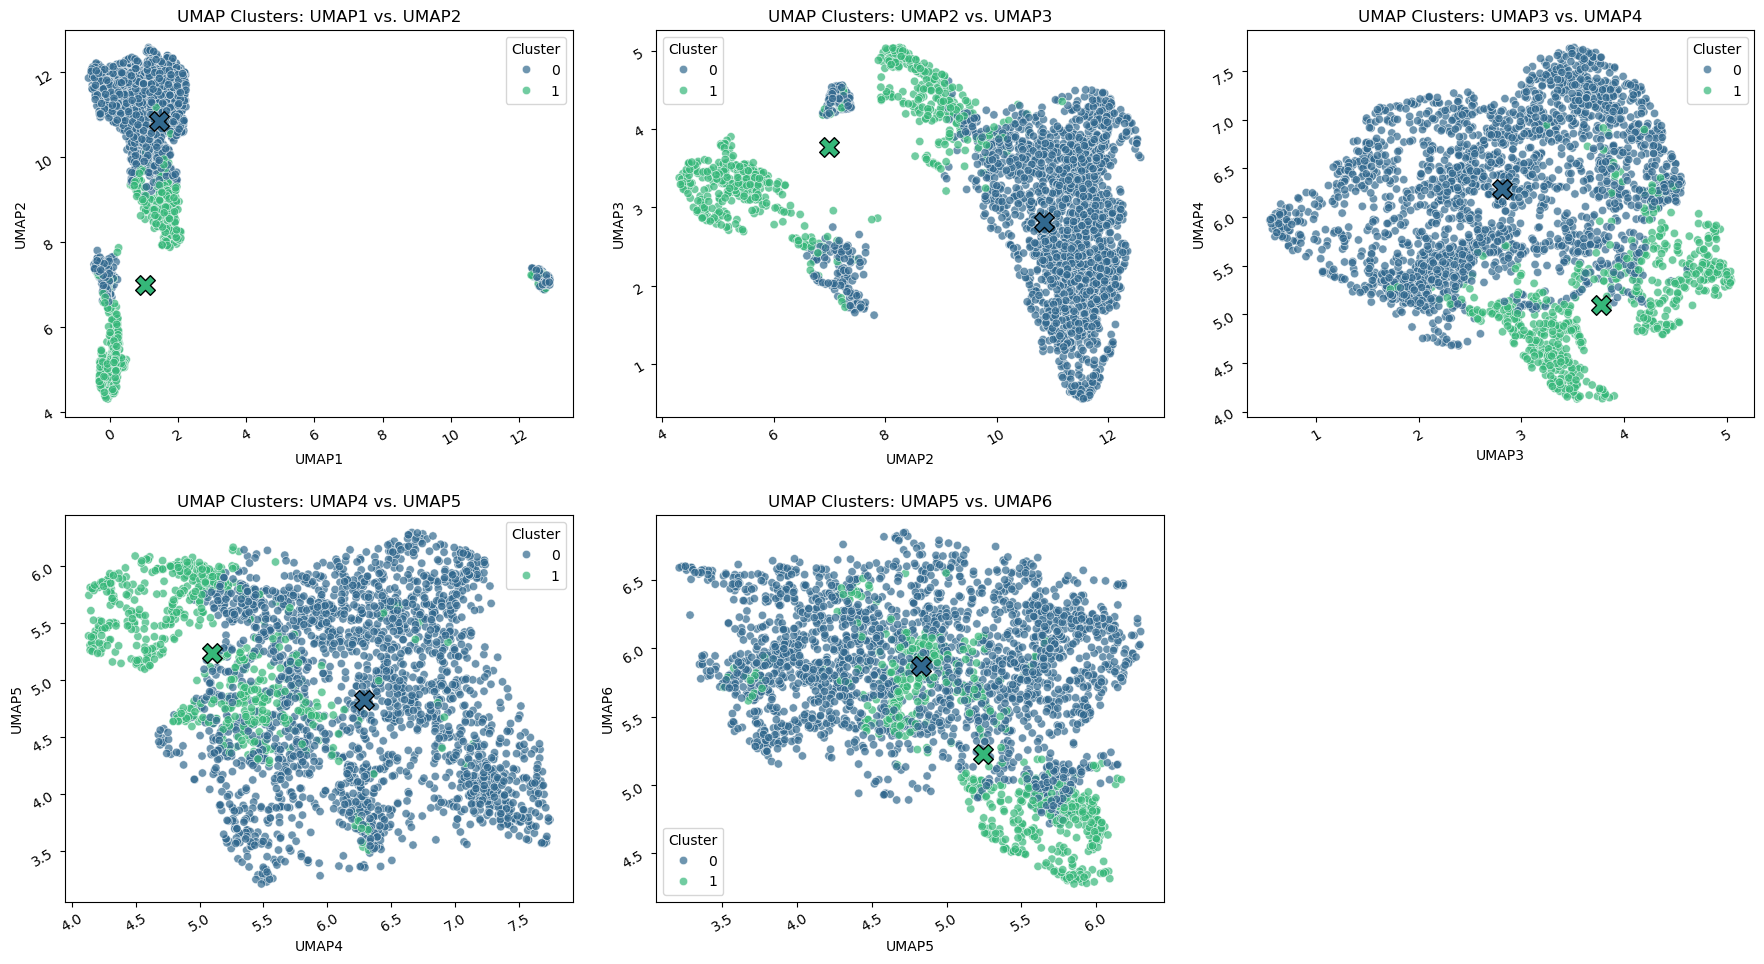

In [11]:
# Compute UMAP embedding if not already done
umap_model = umap.UMAP(n_components=6, random_state=42)
umap_embedding = umap_model.fit_transform(X_scaled_df)

# Create DataFrame for UMAP results
umap_columns = [f"UMAP{i+1}" for i in range(umap_embedding.shape[1])]
umap_df = pd.DataFrame(umap_embedding, columns=umap_columns)
umap_df["Cluster"] = df_sample["Cluster"].values

# Define UMAP component pairs to visualize
umap_pairs = [("UMAP1", "UMAP2"), ("UMAP2", "UMAP3"), ("UMAP3", "UMAP4"), ("UMAP4", "UMAP5"), ("UMAP5", "UMAP6")]

# Create subplots dynamically based on number of pairs
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Adjusted figure size
axes = axes.flatten()

for i, (umap_x, umap_y) in enumerate(umap_pairs):
    ax = axes[i]

    # Scatter plot of UMAP clusters
    sns.scatterplot(
        x=umap_df[umap_x], 
        y=umap_df[umap_y], 
        hue=umap_df["Cluster"].astype(str), 
        palette="viridis", 
        alpha=0.7, 
        ax=ax
    )

    # Compute centroids
    centroids = umap_df.groupby("Cluster")[[umap_x, umap_y]].mean()

    # Extract cluster colors from the scatter plot
    cluster_palette = dict(zip(umap_df["Cluster"].unique(), sns.color_palette("viridis", len(umap_df["Cluster"].unique()))))

    # Plot centroids with matching cluster colors
    for cluster, row in centroids.iterrows():
        ax.scatter(row[umap_x], row[umap_y], marker="X", s=200, c=[cluster_palette[cluster]], edgecolors="black")

    ax.set_xlabel(umap_x)
    ax.set_ylabel(umap_y)
    ax.set_title(f"UMAP Clusters: {umap_x} vs. {umap_y}")

    # Reduce overlapping text labels
    ax.tick_params(axis="x", rotation=30)
    ax.tick_params(axis="y", rotation=30)

# Remove extra empty subplot if needed
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)  # Improve spacing
plt.show()


# Song Recommendation System

In [12]:
import unicodedata

# --- Text Normalization and Cleaning Functions ---
def normalize_text(text):
    return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode()

def clean_text(text):
    return (
        text.lower()
        .strip()
        .replace('"', '')
        .replace("'", "")
        .replace("’", "'")
        .replace(".", "")
        .replace(":", "")
        .strip()
    )

def full_clean_text(text):
    return clean_text(normalize_text(text))

# ---Adding Track name and song ---
df["track_name"] = df["track_name"].astype(str).apply(full_clean_text)
df["artist_name"] = df["artist_name"].astype(str).str.lower().str.strip()

# --- Matching Function with Deduplication ---
def find_all_matches(input_song, input_artist=None, cutoff=0.9, num_matches=5):
    """
    Returns matching songs along with their artist names.
    If input_artist is provided, it first attempts to find exact matches
    on both the song and artist. If none are found, it falls back to match on
    the song name only. Duplicate matches are removed before printing.
    """
    input_song_cleaned = full_clean_text(input_song)
    
    # If the artist is provided, attempt an exact match on both song and artist.
    if input_artist:
        input_artist_cleaned = full_clean_text(input_artist)
        exact_matches_df = df[
            (df["track_name"].str.fullmatch(input_song_cleaned, case=False, na=False)) &
            (df["artist_name"].str.fullmatch(input_artist_cleaned, case=False, na=False))
        ]
        if not exact_matches_df.empty:
            matched_songs = exact_matches_df["track_name"].tolist()
            matched_artists = exact_matches_df["artist_name"].tolist()
            # Deduplicate the (song, artist) pairs while preserving order.
            unique_matches = []
            for pair in zip(matched_songs, matched_artists):
                if pair not in unique_matches:
                    unique_matches.append(pair)
            for song, art in unique_matches:
                print(f"Exact match found: '{song}' by {art}")
            # Unzip unique_matches back into two lists.
            return [pair[0] for pair in unique_matches], [pair[1] for pair in unique_matches]
        else:
            print("Exact match on both song and artist not found. Searching by song name only:")
    
    # Search by song name only.
    exact_matches_song_df = df[df["track_name"].str.fullmatch(input_song_cleaned, case=False, na=False)]
    if not exact_matches_song_df.empty:
        matched_songs = exact_matches_song_df["track_name"].tolist()
        matched_artists = exact_matches_song_df["artist_name"].tolist()
        unique_matches = []
        for pair in zip(matched_songs, matched_artists):
            if pair not in unique_matches:
                unique_matches.append(pair)
        for song, art in unique_matches:
            print(f"Exact match found: '{song}' by {art}")
        return [pair[0] for pair in unique_matches], [pair[1] for pair in unique_matches]
    
    # Fuzzy matching if no exact song match is found.
    all_songs = df["track_name"].dropna().tolist()  # include duplicates here
    closest_matches = difflib.get_close_matches(input_song_cleaned, all_songs, n=num_matches, cutoff=cutoff)
    if closest_matches:
        matched_songs, matched_artists = [], []
        print("Possible close matches:")
        for song in closest_matches:
            song_rows = df[df["track_name"].str.fullmatch(song, case=False, na=False)]
            for _, row in song_rows.iterrows():
                matched_songs.append(row["track_name"])
                matched_artists.append(row["artist_name"])
        # Deduplicate matches.
        unique_matches = []
        for pair in zip(matched_songs, matched_artists):
            if pair not in unique_matches:
                unique_matches.append(pair)
        for song, art in unique_matches:
            print(f"Exact match found: '{song}' by {art}")
        return [pair[0] for pair in unique_matches], [pair[1] for pair in unique_matches]
    else:
        print(f"No matches found for '{input_song}'" + (f" by '{input_artist}'." if input_artist else "."))
        return [], []

# --- Recommendation Function (unchanged) ---
def recommend_song(input_song, cutoff=0.995, similarity_threshold=0.5, pre_matched=False):
    if not pre_matched:
        matched_song, matched_artist = find_all_matches(input_song)
        if isinstance(matched_song, list) and len(matched_song) > 0:
            matched_song = matched_song[0]
            matched_artist = matched_artist[0]
        else:
            return f"Song '{input_song}' not found. Try adjusting filters or verifying spelling."
    else:
        matched_song = input_song

    numeric_features = ["danceability", "energy", "valence", "tempo", "speechiness"]
    matched_idx = df[df["track_name"] == matched_song].index
    if len(matched_idx) == 0:
        return f"Matched song '{matched_song}' not found in dataset."
    
    song_features = df.loc[matched_idx[0], numeric_features].values.reshape(1, -1)
    valid_rows = df.dropna(subset=numeric_features).index
    df_valid = df.loc[valid_rows, numeric_features]
    similarities = cosine_similarity(song_features, df_valid)
    similarity_scores = similarities[0] / similarities[0].max()
    
    df_filtered = df.loc[valid_rows].copy()
    df_filtered["Similarity"] = similarity_scores
    input_artist_val = df_filtered.loc[df_filtered["track_name"] == matched_song, "artist_name"].values[0]
    
    dynamic_threshold = max(similarity_threshold, df_filtered["Similarity"].mean())
    
    recommendations = df_filtered[
        (df_filtered["artist_name"] != input_artist_val) & (df_filtered["Similarity"] >= dynamic_threshold)
    ]
    
    recommendations = recommendations.drop_duplicates(subset=["track_name", "artist_name"])
    
    if "genre" in df.columns:
        input_genre = df.loc[df["track_name"] == matched_song, "genre"].values[0]
        recommendations = recommendations[recommendations["genre"] == input_genre]
    
    recommendations = recommendations.sort_values(
        by=["Similarity", "danceability", "energy"],
        ascending=[False, False, False]
    ).head(10)
    
    if recommendations.empty:
        return f"No recommendations found for '{matched_song}'. Try adjusting filters."
    
    return recommendations[["track_name", "artist_name"]]

# Test Case Handling

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# --- Test Case ---
test_song = "Believe"    # Example (mis-spelled or ambiguous) song name
test_artist = "Cher"     # Provided artist name

# Make sure find_all_matches is defined by running the cell that defines it (cell 26) before running this cell.

# Get matching suggestions using both song and artist.
matched_songs, matched_artists = find_all_matches(test_song, test_artist)
if matched_songs:
    # For recommendations, choose one unique match.
    chosen_song = matched_songs[0]
    chosen_artist = matched_artists[0]
    print(f"\nUsing song: '{chosen_song}' by {chosen_artist} for recommendations.\n")
else:
    print(f"\nNo matching songs found for '{test_song}' by '{test_artist}'.\n")
    chosen_song = test_song  # Fallback to original input

recommended_songs = recommend_song(chosen_song, pre_matched=True)

print("Recommended songs\n")
if isinstance(recommended_songs, pd.DataFrame):
    print(recommended_songs.head())
else:
    print(recommended_songs)


Exact match found: 'believe' by cher

Using song: 'believe' by cher for recommendations.

Recommended songs

                                 track_name     artist_name
5307   rumble (feat jackson wang & lil nei)        goldlink
9648         i like you (feat dram & 6lack)  childish major
9430                                 sirens          sonder
12266                             know love            rkcb
11716                              all i do    majid jordan


# Save Files

In [18]:
# Save the PCA DataFrame to CSV for further analysis
pca_df.to_csv("Output/pca_results.csv", index=False)
# Save the scaled DataFrame to CSV for further analysis
X_scaled_df.to_csv("Output/scaled_features.csv", index=False)
# Save the original DataFrame with clusters to CSV for further analysis
df_sample.to_csv("Output/original_with_clusters.csv", index=False)

# Export the recommended songs DataFrame to a CSV file, only if it's a DataFrame
if isinstance(recommended_songs, pd.DataFrame):
	recommended_songs.to_csv("Output/recommended_songs.csv", index=False)
else:
	print("No recommended songs DataFrame to save.")
